In [12]:
%run ../../common_methods/import_all.py

import cv2
import os

from common_methods.setup_notebook import set_css_style, setup_matplotlib, config_ipython
config_ipython()
setup_matplotlib()
set_css_style()

# Object Detection and recognition

Object detection is the set of methodologies aimed at instructing a machine to understand if there is something in the image and where it is. These days Deep Learning approaches are the state-of-the-art silver bullets for these types of tasks, however the approaches described here are nevertheless brilliant and still useful in many cases. Read this very nice [[blog]](#comparison) on a comparison between these traditional computer vision methods compared to deep learning methods for the detection of objects in an image.

The descriptors (the features) used for the detection of objects can also be used for the recognition of whether images are similar; one typical use case is to scan a set of images of faces to retrieve the most similar ones to the one at hand.

## Haar cascades

Haar cascades, whose original paper by Viola and Jones [[1]](#haar), dates back from 2001 and it's a brilliant piece of work. It works by training a **cascade classifier** on positive (contain object) and negative (do not contain object) images. The word *Haar* (a name, originally) for this algorithm comes from the fact that the features it is trained on are called *Haar features* and this is due to the fact that they mirror the Haar wavelets, a family of step (mathematical) functions conceived by A Haar back at the start of the twentieth century [[2]](#wavelets). 

The idea of the Haar features has been formalised in the aforementioned paper, which has actually been inspired by a slightly older paper (1998) by Papageorgiou et al [[3]](#papa). 

### Haar features

<img src="../../imgs/haar.jpg" width="500"/>

The figure above illustrates the Haar features, which are of three types: 

* (A): *edge* features;
* (B): *line* features;
* (C): *four-rectangle* features

The Haar classifier is trained by moving these rectangles over each training image and computing the sum of of pixels' intensities under the dark and the light areas; afterwards, the differences of these is computed and compared to a threshold, which is meant to separate object from no-object in the training images. For example, to detect eyes, because the pixels in the eyes regions are darker than those in the cheeks, a line feature with the dark part above would be a good feature.

### Implementation of the training process

<img src="../../imgs/integral-image.jpg" align="left" width="300" style="margin:20px 50px"/>

Because the Haar features procedure would have to be run on each subsection of the image, the training process would be unfeasible with many images. What actually happens is that the algorithm uses *integral images*: 2-dimensional lookup tables containing the sum of pixels in the top-left part of the original image. The Figure on the left illustrates the concept, which can be formulated as 

$$
I(x, y) = \sum_{x' \leq x, y' \leq y} i(x', y') \ ,
$$

meaning that the value at point $(x, y)$ in table is the sum of all pixels above and to the left of it. From the image, the sum would be $D-B-C+A$, where the letters indicate the respective areas top-left of points: only four lookups are then needed,  and here is why this makes everything much faster.

### The classifier and the cascades

This way, a weak classifier for each feature is built. A strong classifier, an **AdaBoost**, weights all these weak classifiers and is capable of selecting the most relevant features as well. These strong classifiers are then organised into a **cascade**, whereby there is one at each stage.

Authors of the paper proved a very high accuracy with 600 features and a $95\%$ accuracy with 200 features in the case of face detection.

### Detecting a human/face with OpenCV and Haar cascades

OpenCV comes with some [already trained](https://github.com/opencv/opencv/tree/master/data/haarcascades) Haar cascade classifiers for human detection, but also for the detection of cats and car plates (quite handy!). The ones about humans have been trained for the detection of

* frontal face
* profile face
* eye
* eye behind glasses
* full body
* lower body
* upper body
* smiles

We will use the frontal face model to demonstrate the detection of a face in an image and the eye model to detect eyes as well. This follows this OpenCV [tutorial](http://docs.opencv.org/3.1.0/d7/d8b/tutorial_py_face_detection.html).

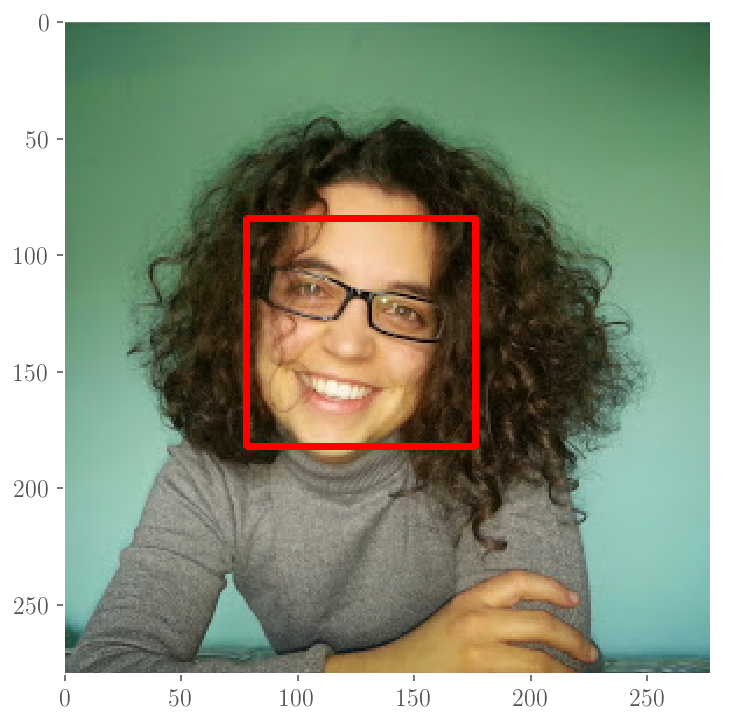

In [17]:
# Read image: we'll use my beautiful face ... (transform into RGB as OpenCV reads in BGR)
image = cv2.imread('../../imgs/foto_martina.jpg')
RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Transform image in grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# use the trained model for frontal face
# have to pass path to where model is stored
face_cascade = cv2.CascadeClassifier(os.getenv('HOME') + 
                                     '/Desktop/packages/opencv-3.2.0/data/haarcascades/' + 
                                     'haarcascade_frontalface_default.xml')

# detect my face and where it is (draw ROI around it), detection is on the grayscale one
objects = face_cascade.detectMultiScale(image_gray, scaleFactor=1.3, minNeighbors=5)
for (x,y,w,h) in objects:
    cv2.rectangle(RGB_image, (x,y), (x+w,y+h), (255, 0, 0), 2)
        
plt.imshow(RGB_image)
plt.grid()
plt.show();

## Local Binary Patterns: LBP

LBPH, standing for *Local Binary Pattern Histograms*, [[3]](#3) is a 2-dimensional texture analysis method which consists in comparing each pixel with its neighbourhood. 

<img src="../../imgs/lbph-pixels.jpg" align="left" width="300" style="margin:0px 50px"/>

Consider the situation illustrated in the figure here: the image is transformed into a matrix of binary numbers, so that $2^8$ combinations are possible, given that in 2 dimensions each pixel has 8 neighbours. Here is where *binary* in the name of the method comes from. A pixel and its neighbourhood are depicted: if the neigbouring pixel has higher intensity, it gets a 1, otherwise it gets a 0.

The LBP operator is defined as, in a generic $p$-dimensional space,

$$
LBP(x_c, y_c) = \sum_{k=0}^{k=p-1} 2^k S(i_p-i_c) \ ,
$$

where $i$ indicates the pixel's [intensity](../some-glossary.ipynb#Intensity), $(x_c, y_c)$ is the central pixel under consideration and  $S(x)$  is the sign function:

$$
S(x) =
\left\{
	\begin{array}{ll}
		1  & \mbox{if } x \geq 0 \\
		0 & \mbox{if } x < 0
	\end{array}
\right.
$$

This method captures fine-grained details. However, a fixed neighbourhood cannot encode details which differ in scale, so the operator has been modified to account for a variable neighborhood [[4]](#4) so that an arbitrary number of pixels is aligned on a circle with variable radius to capture the neighbourhoods (see figure).

<img src="../../imgs/lbph-circle.jpg" width="500"/>

For a given point $(x_c, y_c)$, the neighbour $(x_p, y_p)$, with $p \in D$ ($D$ being the number of dimensions), can be calculated as

$$
\begin{cases}
x_p = x_c + R \cos(\frac{2 \pi p}{D}) \\
y_p = y_c - R \sin(\frac{2 \pi p}{D})
\end{cases}
$$

The operator is an extension of the LBP one. If a point on the circle does not correspond to the image coordinate, it gets interpolated.

The recognition of faces works by dividing the LBP image in local regions and extracting a histogram from each region. The local histograms, concatenated, give a spatially enhanced feature vector.

## Histogram of Oriented Gradients (HOG)

The Histogram of Oriented Gradients (*HOG*) is a methodology used for object detection [[6]](#hog) which count the occurrences of gradient orientation in localised portions of the image. A local object can be described by a distribution of intensity gradients. The image gets divided into cells and for each cell a histogram of the gradient directions is computed. 

The descriptor is a concatenation of these histograms. For accuracy reasons, the local histograms are normalised with a measure of intensity across a larger region of the image (block) which guarantees better invariance to changes in illumination and shadowing.

Advantages: a local cell is invariant to geometrical and photometric transformations except for the object orientation. This makes the method particularly suited for the recognition of humans (pedestrians) in the image as sampling permits individual body movements to be ignored so long as the upright position is mantained.

After extracting the features with a HOG descriptor, a SVM classifier is applied.

## Eigenfaces and Fisherfaces

These descriptors are used in the context of *face recognition*, to teach a machine when faces are similar. As humans, recognising a person by his/her face is a very quick task, mundane even for our daily life, although the specifics of what happens in the human brain are still to be fully understood. This [[article]](#sciam) narrates a recent breakthrough (at the time of writing this at least) on the topic.

As machines though, the situation is different. There have been approaches based on vectors built with geometrical features [[1]](#kanade), but they have been proven to not be good enough. Standard methods today consist in training a Machine Learning classifier (we are not considering recent Deep Learning approaches here).

### Eigenfaces

The *eigenfaces* (yes, they are really called like that) are the set of eigenvectors outlining the major properties of a face and derived via PCA and used to train a classifier. [Wikipedia](https://en.wikipedia.org/wiki/Eigenface) has a good page on the topic.

An image is a high-dimensional object and not all the features which can be inferred from its pixels are relevant. The steps of the algorithm computing the eigenfaces are:

1. Use a large training set of images of faces, ideally taken under the same light conditions;
2. Normalise them in such a way to have eyes and mouth aligned and then resampled to the same pixel resolution;
2. Perform a PCA and project the original images onto the chosen components;
3. The query image is then projected on the principal components as well;
4. Use a distance method to compare the projected query image and the projected training images

The problem with computing the PCA on many large images is about performance. With 400 $10^2 \times 10^2$ images, the covariance matrix will be $10^4 \times 10^4$. Thankfully though, note that a $M \times N$ matrix with $M > N$ has only $N-1$ non-zero eigenvalues, so the problem becomes much more accessible.

In fact what we can do is apply this little small trick. Instead of the eigenvalues and eigenvectors of $XX^T$, where  $X$ is the dataset matrix,  which is a $M \times M$ matrix, we can use the eigenvalues and eigenvectors of $X^TX$, which is a  $N \times N$ matrix, much smaller. Because matrix multiplication is associative, this gives:

\begin{align*}
 	(X^TX) \mathbf{v} &= \lambda \mathbf{v} \\
 	X(X^TX) \mathbf{v} &=  \lambda  X \mathbf{v} \\
 	(XX^T)(X \mathbf{v}) &=  \lambda  (X \mathbf{v})
\end{align*}

### Fisherfaces

A PCA in the eigenfaces approach finds linear combinations of features that maximise the total variance in the data. This way, some discriminative information can be lost when throwing away the components which do not contribute much to the variance. This is particularly a problem when variance is generated by an external source in the images, like light and this is why that approach works well only when images are taken in the same conditions.

The Fisherface approach is a sort of correction on this problem which uses a Linear Discriminant Analysis, which allows for class-specific dimensionality reduction. See this nice page on [Scholarpedia](http://www.scholarpedia.org/article/Fisherfaces).

## References

1. <a name="haar"></a> P Viola, M Jones, [**Rapid object detection using a boosted cascade of simple features**](http://www.merl.com/publications/docs/TR2004-043.pdf), *Proceedings of the 2001 IEEE Computer Society Conference on Computer Vision and Pattern Recognition*, 1, 2001
2. <a name="wavelets"></a> [Wikipedia](https://en.wikipedia.org/wiki/Haar_wavelet) on Haar wavelets
3. <a name="papa"></a> C P Papageorgiou, M Oren, T Poggio, **A general framework for object detection**, *IEEE sixth international conference on Computer vision*, 1998
4. <a name="blog"></a> A nice [blog](https://singhgaganpreet.wordpress.com/2012/10/14/training-haar-cascade/) on the training of Haar cascades
5. <a name="hc-wiki"></a> [Wikipedia](https://en.wikipedia.org/wiki/Viola–Jones_object_detection_framework#Cascade_architecture) on the Viola-Jones work
6. <a name="hog"></a> N Dalal, B Triggs, [Histograms of oriented gradients for human detection](https://hal.inria.fr/file/index/docid/548512/filename/hog_cvpr2005.pdf), *2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition*, 1 IEEE, 2005
7. <a name="sciam"></a> [How we save face -- Researchers crack the brain's facial recognition code](https://www.scientificamerican.com/article/how-we-save-face-researchers-crack-the-brains-facial-recognition-code/), *Scientific American*, 1 June 2017
8. <a name="kanade"></a> T Kanade, [*Picture processing system by computer complex and recognition of human faces*](http://www.ri.cmu.edu/pub_files/pub3/kanade_takeo_1973_1/kanade_takeo_1973_1.pdf), Doctoral Thesis, Kyoto University, 1973
9. <a name="3"></a> T Ojala, M Pietikainen, D Harwood, [Performance evaluation of texture measures with classification based on Kullback discrimination of distributions](http://ieeexplore.ieee.org/abstract/document/576366/), *Pattern Recognition, Proceedings of the 12th IAPR International Conference, IEEE*, 1, 1994
10. <a></a> T Ahonen, A Hadid, M Pietikainen, [Face description with local binary patterns: Application to face recognition](https://pdfs.semanticscholar.org/7476/922f1f6b69d9425b013613442bd4ee099fbe.pdf), *IEEE transactions on pattern analysis and machine intelligence*, 28:12, 2006
11. <a name="4"></a> [A very well done and detailed explanation of the three methods and usage in OpenCV](http://eyalarubas.com/face-detection-and-recognition.html)
12. <a name="5"></a> Y S Liu W S Ng C W Liu, [A comparison of different face recognition algorithms](http://cs.unc.edu/~chunwei/papers/2009pr_face_recog.pdf)
13. I Ozhiganov, [**Convolutional Neural Networks vs. Cascade Classifiers for Object Detection**](https://dzone.com/articles/cnn-vs-cascade-classifiers-for-object-detection), 2017